# Second order Neurons testing

## Setup

In [3]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([])

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

## Synaptic example

In [5]:
# Temporal dynamics
alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

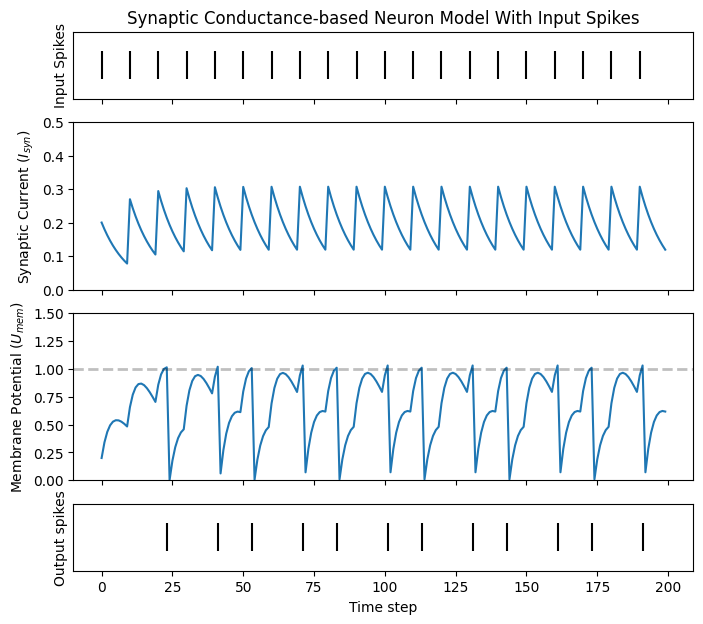

In [6]:
# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

## Synaptic Experiments

Running sweep with weight w=0.2...


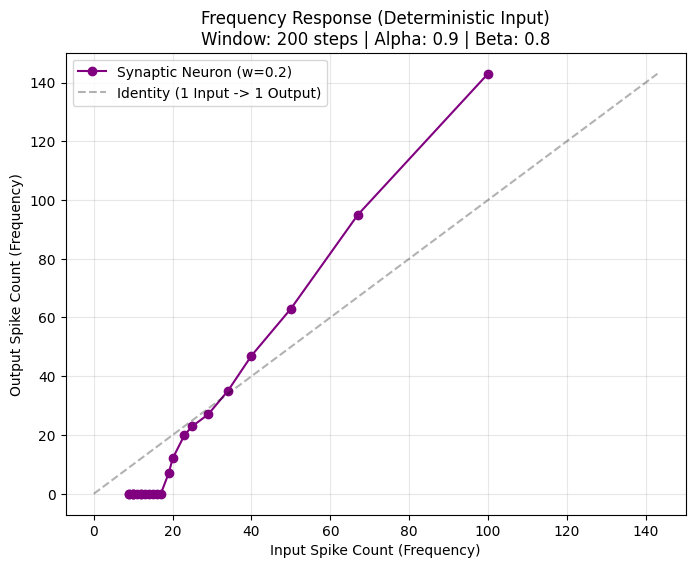

In [15]:
import torch
import snntorch as snn
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup Parameters ---
alpha = 0.9
beta = 0.8
num_steps = 200 # Fixed window size
w = 0.2         # Input weight

# Initialize Neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

# --- 2. Define Deterministic Frequencies (Periods) ---
# We test firing every N steps: from every 2nd step (fast) to every 20th step (slow)
firing_periods = range(2, 25) 

input_counts = []
output_counts = []

print(f"Running sweep with weight w={w}...")

# --- 3. Experiment Loop ---
for period in firing_periods:
    # A. Create Deterministic Input
    # Create a single cycle: 1 spike followed by (period-1) zeros
    cycle = torch.zeros(period)
    cycle[0] = w 
    
    # Repeat cycle to fill the num_steps window
    num_repeats = (num_steps // period) + 1
    spk_in = cycle.repeat(num_repeats)[:num_steps] # Trim to exact length
    
    # Record actual input count
    # (We assume spk_in > 0 is a spike)
    input_c = (spk_in > 0).sum().item()
    input_counts.append(input_c)
    
    # B. Reset Neuron
    syn, mem = lif1.init_synaptic()
    spk_out_count = 0
    
    # C. Run Simulation
    for step in range(num_steps):
        spk_out, syn, mem = lif1(spk_in[step], syn, mem)
        spk_out_count += spk_out.item()
        
    output_counts.append(spk_out_count)

# --- 4. Plotting ---
plt.figure(figsize=(8, 6))

# Plot the data
plt.plot(input_counts, output_counts, marker='o', linestyle='-', color='purple', label=f'Synaptic Neuron (w={w})')

# Plot the "1-to-1" line (Identity)
# If the neuron was perfect, it would match this line
max_val = max(max(input_counts), max(output_counts))
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Identity (1 Input -> 1 Output)')

plt.title(f"Frequency Response (Deterministic Input)\nWindow: {num_steps} steps | Alpha: {alpha} | Beta: {beta}")
plt.xlabel("Input Spike Count (Frequency)")
plt.ylabel("Output Spike Count (Frequency)")
plt.legend()
plt.grid(True, alpha=0.3)

# Invert X-axis purely for visualization if you prefer "Fast -> Slow" left-to-right?
# Standard is Low Freq -> High Freq (Left -> Right), so we keep as is.
# Low input count = Low Frequency.

plt.show()

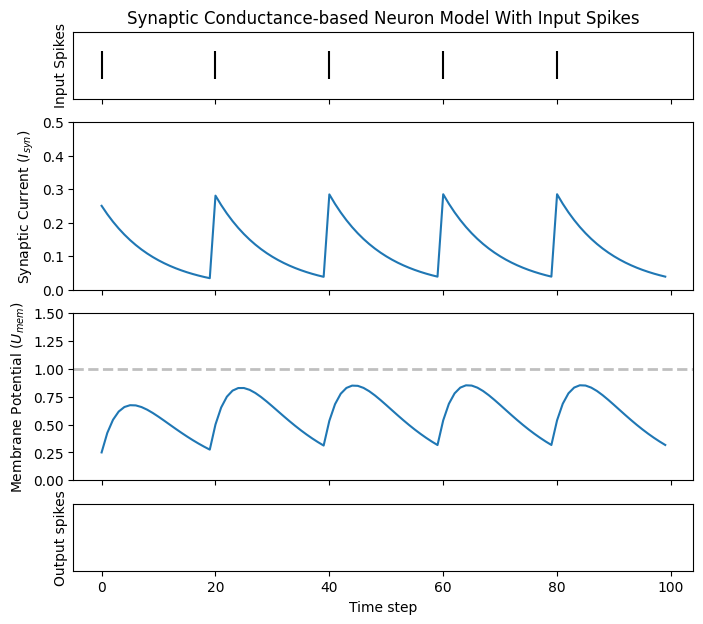

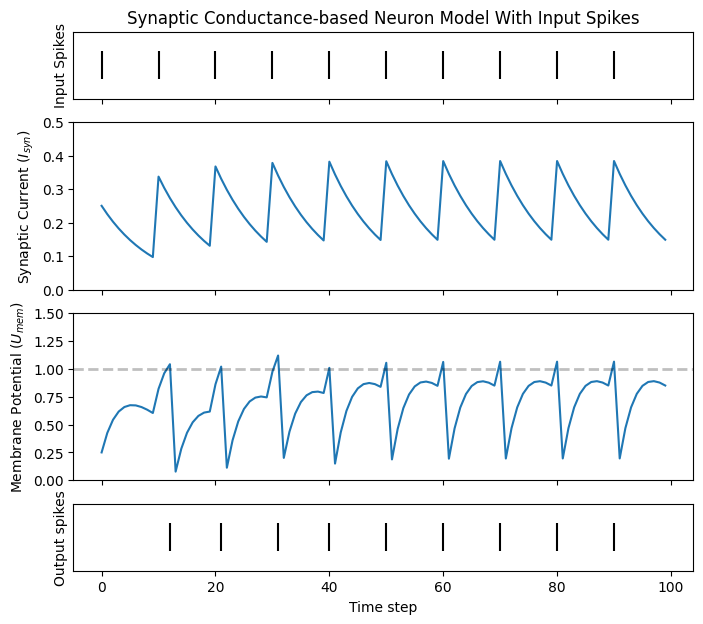

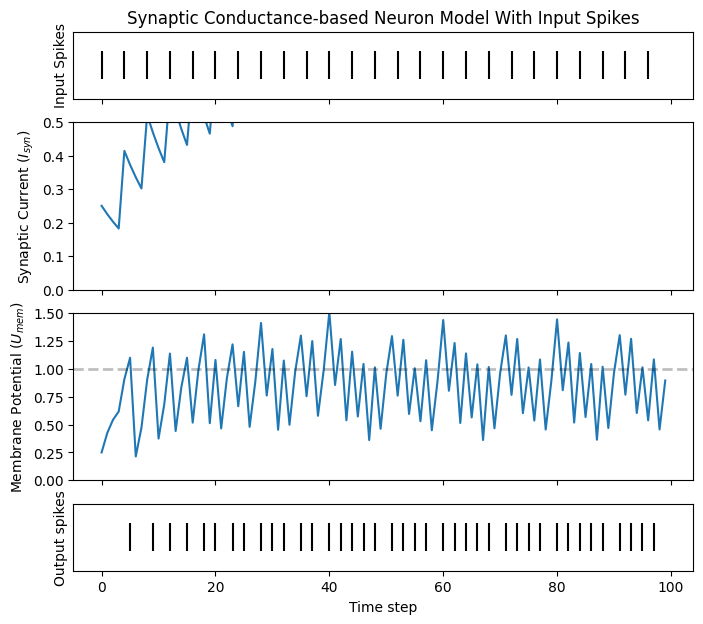

In [16]:

# --- 2. Simulation Setup ---
alpha = 0.9
beta = 0.8
w = 0.25 # Slightly bumped up to make the "Medium" case more interesting
num_steps = 100

lif1 = snn.Synaptic(alpha=alpha, beta=beta)

# Define 3 Rates: (Period = Spikes happen every N steps)
scenarios = [
    {"name": "Low Frequency (Period=20)", "period": 20},
    {"name": "Medium Frequency (Period=10)", "period": 10},
    {"name": "High Frequency (Period=4)", "period": 4}
]

# --- 3. Run & Plot Loop ---
for sc in scenarios:
    period = sc["period"]
    
    # Create Input
    # 1 spike, followed by period-1 zeros
    cycle = torch.zeros(period)
    cycle[0] = w
    num_repeats = (num_steps // period) + 1
    spk_in = cycle.repeat(num_repeats)[:num_steps]
    
    # Run Sim
    syn, mem = lif1.init_synaptic()
    syn_rec = []
    mem_rec = []
    spk_rec = []
    
    for step in range(num_steps):
        spk_out, syn, mem = lif1(spk_in[step], syn, mem)
        spk_rec.append(spk_out)
        syn_rec.append(syn)
        mem_rec.append(mem)
        
    # Stack
    spk_rec = torch.stack(spk_rec)
    syn_rec = torch.stack(syn_rec)
    mem_rec = torch.stack(mem_rec)
    
    # Plot
    plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, sc["name"])

## Alpha example

In [7]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

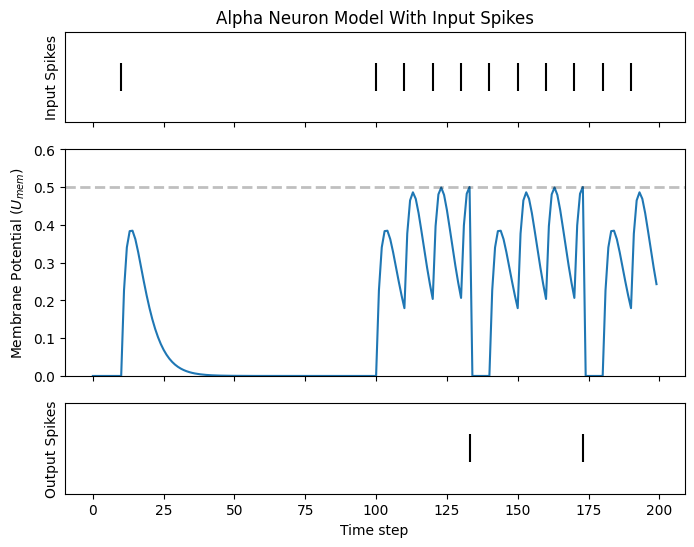

In [8]:
# input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")